<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/storgae/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install sklearn
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=4e86ebe10d74d9c23032631c87150cef663178b32bdb8e86580e0d01e3682c73
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
from scipy import signal
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [83]:

def lowpass_filter(data, cutoff, order):
  nyq = 0.5 * data.shape[-1]
  b, a = signal.butter(order, cutoff/nyq, 'lowpass')
  zi = signal.lfilter_zi(b, a)
  y, _ = signal.lfilter(b, a, data, zi=zi*data[0])
  return y

def SamplesToFreq(x,sample_rate):
  frequency = sample_rate / x
  return frequency

           sam1      sam2      sam3      sam4    target
9999   0.521464  0.566409  0.372406  0.261432  0.452536
10000  0.516122  0.566717  0.372234  0.261174  0.453623
10001  0.512043  0.564974  0.371260  0.260362  0.455616
10002  0.514075  0.567699  0.372065  0.260783  0.460507
10003  0.514682  0.569719  0.372573  0.260998  0.449638
...         ...       ...       ...       ...       ...
93079  0.485494  0.558325  0.553928  0.525291  0.481159
93080  0.483031  0.556171  0.552809  0.524556  0.469203
93081  0.492723  0.559589  0.553915  0.525363  0.459601
93082  0.496497  0.559939  0.553655  0.525224  0.446014
93083  0.494690  0.558441  0.552722  0.524612  0.454348

[83085 rows x 5 columns]


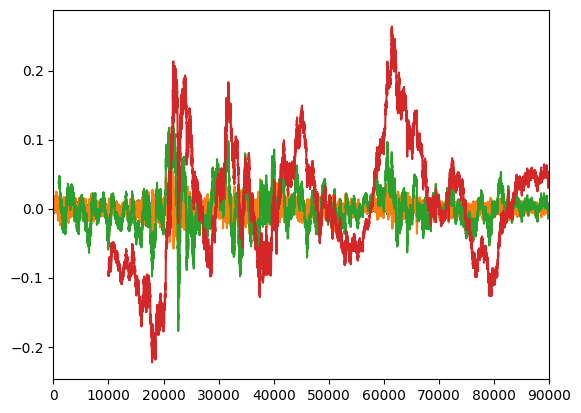

In [136]:

data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = data.pop("BC")

sample_rate = len(close)


samples_per_cycle = sample_rate / 10
frequency = sample_rate / 100

diff = np.diff(close)
sma1 = ta.sma(close,10)
sma2 = ta.sma(close,100)
sma3 = ta.sma(close,1000)
sma4 = ta.sma(close,10000)
new1 = lowpass_filter(close,SamplesToFreq(100,sample_rate),1)
new2 = lowpass_filter(close,SamplesToFreq(1000,sample_rate),1)

target = close.shift(+1).ffill()
target = np.diff(target,prepend=True)

sam1 = np.subtract(sma1,close)
sam2 = np.subtract(sma2,close)
sam3 = np.subtract(sma3,close)
sam4 = np.subtract(sma4,close)

x_min = 0
x_max = 90000
plt.plot(sam1)
plt.plot(sam2)
plt.plot(sam3)
plt.plot(sam4)
plt.xlim(x_min, x_max)


testdata = pd.DataFrame({'sam1':sam1,'sam2':sam2,'sam3':sam3,'sam4':sam4,'target':target},columns=['sam1', 'sam2', 'sam3', 'sam4','target'])
testdata = testdata.dropna()
scaled = (testdata-testdata.min())/(testdata.max()-testdata.min())
print(scaled)

0       344700.0
1       176500.0
2       270500.0
3       330000.0
4        81700.0
          ...   
2995    225000.0
2996    237200.0
2997     62000.0
2998    162500.0
2999    500001.0
Name: median_house_value, Length: 3000, dtype: float64
[[-1.21764     0.91299186 -0.13216279 ...  0.45190479  0.67815547
   1.4836834 ]
 [ 0.61130285 -0.55589886  1.12275824 ... -0.62445889 -0.66485033
   0.08058872]
 [ 0.89510272 -0.87626912 -0.13216279 ...  0.38844189  0.30651793
   1.18971107]
 ...
 [-0.14185486  0.50077947 -1.52019661 ... -0.84488057 -0.98623556
  -0.91436025]
 [ 1.31268951 -0.65895768  0.8907214  ... -2.42400685 -2.46736827
  -0.13936636]
 [-0.10621082 -0.45633209  1.04556877 ... -0.72887278 -0.75731682
   2.01941996]]


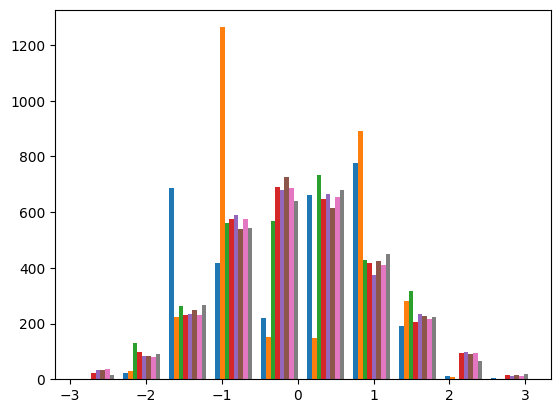

In [ ]:
df = pd.read_csv('/content/sample_data/california_housing_test.csv')
target = df.pop("median_house_value")

df = 1+(df-df.min())/(df.max()-df.min())



rng = np.random.RandomState(0)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
df = pt.fit_transform(df)

ax = plt.hist(df)

print(target)
print(df)

In [139]:
from keras.regularizers import Regularizer
reg = tf.keras.regularizers.L2(l2=0.01)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(25, activation='relu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(25, activation='relu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
loss_fn = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['RootMeanSquaredError'])

In [141]:
#target = scaled.pop('target')


hist = model.fit(scaled, target, epochs=10, batch_size=32)

Epoch 1/10
2597/2597 [==============================] - 8s 2ms/step - loss: 0.0808 - root_mean_squared_error: 0.0513
Epoch 2/10
2597/2597 [==============================] - 7s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 3/10
2597/2597 [==============================] - 12s 5ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 4/10
2597/2597 [==============================] - 10s 4ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 5/10
2597/2597 [==============================] - 9s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 6/10
2597/2597 [==============================] - 7s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 7/10
2597/2597 [==============================] - 9s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 8/10
2597/2597 [==============================] - 7s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.0289
Epoch 9/10
2597/2597 [==============================] - 5s 2ms

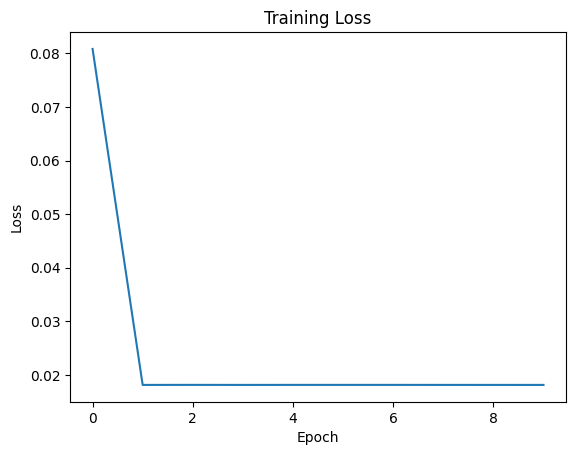

In [142]:
# Plot the training loss
plt.plot(hist.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [144]:
prediction = model.predict(scaled)

2597/2597 [==============================] - 5s 2ms/step


In [ ]:
plt.plot(prediction)